# Transformers Part 2

Data prepration and forecasting with State Space Model and Temporal Fusion Transformer Model. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries

# Do not show specific warnings from statsmodels
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

## Load Time Series Data

In [2]:
# Load the prepared data frame
# Weather data derived from DWD climate data summary with daily measurements for station 02932 (Leipzig)
df = pd.read_csv("data/dwd_02932_climate_prepared.csv", sep=";", parse_dates=["date"], index_col="date")
# Create a smaller subset of temperature_air_mean_2m for visualization purposes
df_temp_visu = df['temperature_air_mean_2m'].loc["2019":]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18263 entries, 1975-01-01 to 2024-12-31
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   wind_gust_max            18263 non-null  float64
 1   wind_speed               18263 non-null  float64
 2   precipitation_height     18263 non-null  float64
 3   precipitation_form       18263 non-null  float64
 4   sunshine_duration        18263 non-null  float64
 5   snow_depth               18263 non-null  float64
 6   cloud_cover_total        18263 non-null  float64
 7   pressure_vapor           18263 non-null  float64
 8   pressure_air_site        18263 non-null  float64
 9   temperature_air_mean_2m  18263 non-null  float64
 10  humidity                 18263 non-null  float64
dtypes: float64(11)
memory usage: 2.2 MB


Here, we define the target variable we want to forecast (e.g. temperature) and the covariates (e.g. humidity) that might help improve prediction accuracy. This is critical for multivariate models like transformers that learn from external signals.

In [3]:
# Load data into darts TimeSeries object
# Target series - we want tp predict the values for temperature_air_mean_2m
ts_target = TimeSeries.from_dataframe(df.reset_index(), time_col="date", value_cols=['temperature_air_mean_2m'])
ts_target = ts_target.astype(np.float32)
# Covariate series - we want to make use of the correlation between temperature_air_mean_2m and pressure_vapor, humidity
ts_covs = TimeSeries.from_dataframe(df.reset_index(), time_col="date", value_cols=['pressure_vapor', 'humidity'])
ts_covs = ts_covs.astype(np.float32)
# Check the data
print(ts_target.start_time(), ts_target.end_time())
print(ts_target.components)
print(ts_covs.start_time(), ts_covs.end_time())
print(ts_covs.components)

1975-01-01 00:00:00 2024-12-31 00:00:00
Index(['temperature_air_mean_2m'], dtype='object', name='component')
1975-01-01 00:00:00 2024-12-31 00:00:00
Index(['pressure_vapor', 'humidity'], dtype='object', name='component')


## Train-Test-Split

We divide the data into a training and validation/test set to evaluate model performance on unseen data. This helps us ensure that our model generalizes well and avoids overfitting.

In [4]:
ts_target_train, ts_target_val = ts_target.split_before(pd.Timestamp("2023"))
print("Targets train and validation split")
print(ts_target_train.start_time(), ts_target_train.end_time())
print(ts_target_val.start_time(), ts_target_val.end_time())
print("Covariates train and validation split")
ts_covs_train, ts_covs_val = ts_covs.split_before(pd.Timestamp("2023"))
print(ts_covs_train.start_time(), ts_covs_train.end_time())
print(ts_covs_val.start_time(), ts_covs_val.end_time())

Targets train and validation split
1975-01-01 00:00:00 2022-12-31 00:00:00
2023-01-01 00:00:00 2024-12-31 00:00:00
Covariates train and validation split
1975-01-01 00:00:00 2022-12-31 00:00:00
2023-01-01 00:00:00 2024-12-31 00:00:00


## Covariates

Kinds of covariates:
* past covariates are known only into the past (e.g. historic measurements)
* future covariates are known into the future (e.g. known forecasts or modeled datetime attributes)
* static covariates are constant over time (e.g. station ID, stations latitude-longitude and elevation)

Different models and implementations support different types of coraviates - for darts check: https://unit8co.github.io/darts/userguide/covariates.html

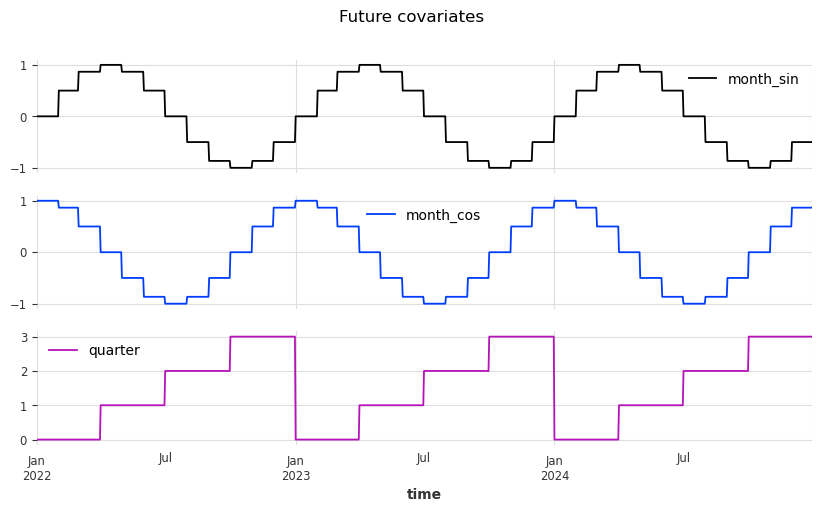

In [5]:
# Future covariates can be modeled
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Model the month as a cyclic sinus / cosinus feature for the training data and 729 days into the future
future_covs = datetime_attribute_timeseries(ts_target_train, attribute="month", cyclic=True, add_length=729)
# Encode the quarter for the training data and 729 days into the future
future_covs = future_covs.stack(
    datetime_attribute_timeseries(ts_target_train, attribute="quarter", add_length=729)
)
future_covs = future_covs.astype(np.float32)

# Plot the future covariates
future_covs.pd_dataframe().loc['2022':].plot(figsize=(10, 5), title="Future covariates", subplots=True)
plt.show()

## Forecasting with Kalman Filter

The Kalman Filter is a classic state space model used for time series forecasting. We include it here as a baseline — it’s useful for comparing traditional models with newer deep learning approaches.
 
* Its main parameter is the size of the Kalman filter state vector.
* You can also toggle the use of the future covariates we modeled before.

In [6]:
from darts.models.forecasting.kalman_forecaster import KalmanForecaster

def model_plot_kalman(state_vector_size=5, use_covariates=False):
    kalman = KalmanForecaster(dim_x = state_vector_size)
    kalman.fit(ts_target_train, future_covariates = future_covs if use_covariates else None)
    pred_kalman = kalman.predict(729, future_covariates = future_covs if use_covariates else None)

    fig, ax = plt.subplots(figsize=(12, 5))
    sns.lineplot(x=df_temp_visu.loc[:"2022"].index, y=df_temp_visu.loc[:"2022"], alpha=0.5, color='blue', label='Original for training', ax=ax)
    sns.lineplot(x=df_temp_visu.loc["2023":].index, y=df_temp_visu.loc["2023":], alpha=0.5, color='grey', label='Original to predict', ax=ax)
    sns.lineplot(x=pred_kalman.pd_series().index, y=pred_kalman.pd_series(), color='red', linewidth=0.5,
        label=f'Kalman Forecast - vecor dim: {state_vector_size}, use covs: {use_covariates}', ax=ax)
    plt.show()

Check how both parameters influence the models' quality in the code cell below - adapt the values and execute the cell.

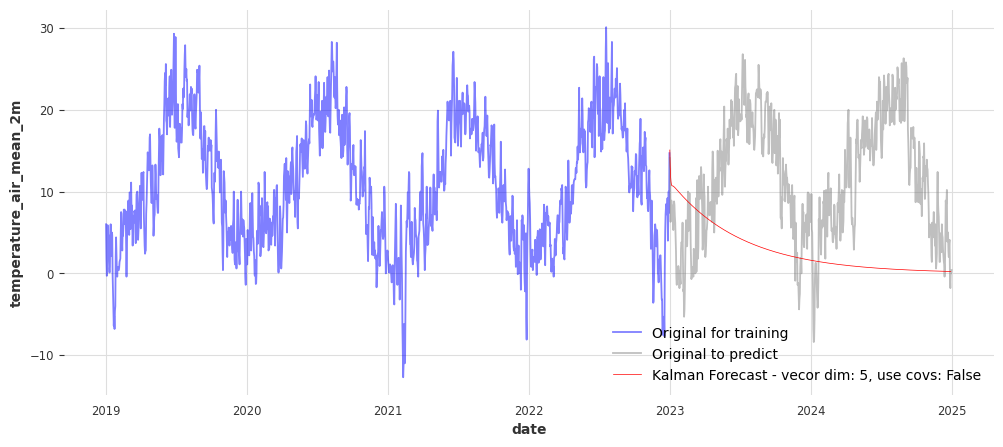

In [26]:
model_plot_kalman(state_vector_size=5, use_covariates=False)

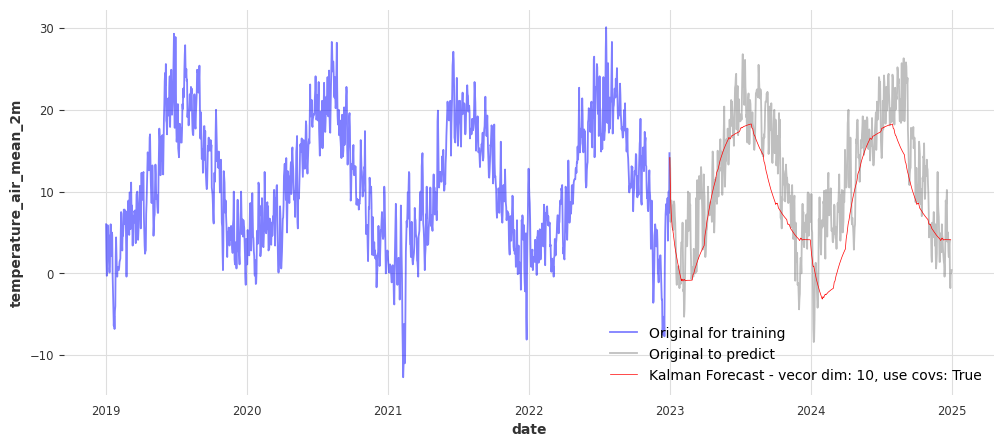

In [27]:
model_plot_kalman(state_vector_size=10, use_covariates=True)

## Forecasting with Temporal Fusion Transformer

Now we apply a modern deep learning model — the Temporal Fusion Transformer (TFT). This model is designed to handle complex, multivariate time series with attention mechanisms, interpretability, and support for probabilistic forecasting.

**From darts' docs (https://unit8co.github.io/darts/userguide.html):**

Darts' TFTModel incorporates the following main components from the original Temporal Fusion Transformer (TFT) architecture:

* Gating mechanisms: skip over unused components of the model architecture
* Variable selection networks: select relevant input variables at each time step
* Temporal processing of past and future input with LSTMs (long short-term memory)
* Multi-head attention: captures long-term temporal dependencies
* Prediction intervals: per default, produces quantile forecasts instead of deterministic values

### Data Scaling

Transformers, like most ML models, are sensitive to the scale of input features. Scaling the data ensures faster and more stable training, and helps the model treat all variables fairly.

In [8]:
from darts.dataprocessing.transformers import Scaler
# Uses sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1)

In [9]:
# Scale the time series (note: we avoid fitting the transformer on the validation set)
transformer_target = Scaler()
train_transformed = transformer_target.fit_transform(ts_target_train)
val_transformed = transformer_target.transform(ts_target_val)
series_transformed = transformer_target.transform(ts_target)

In [10]:
# Scale the past covariates
transformer_past_covs = Scaler()
past_covs_train_transformed = transformer_past_covs.fit_transform(ts_covs_train)
past_covs_val_transformed = transformer_past_covs.transform(ts_covs_val)

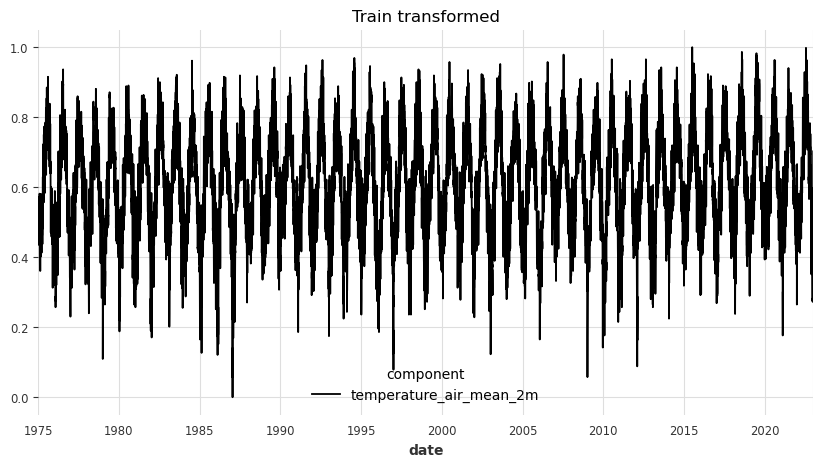

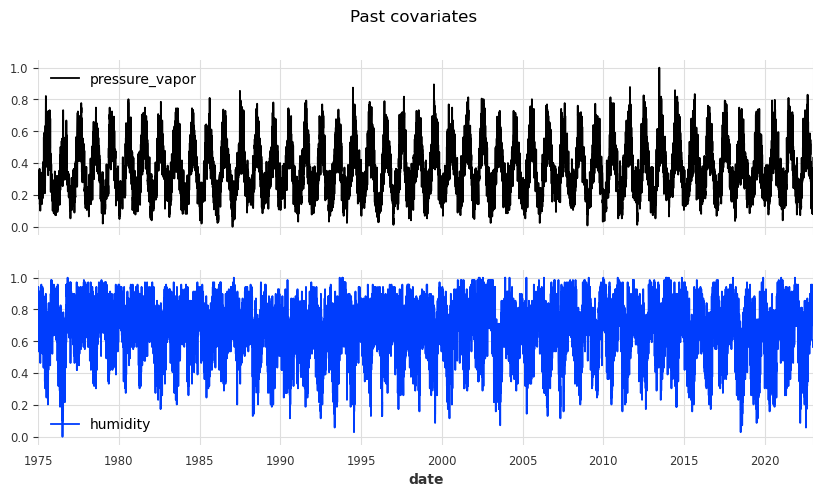

In [11]:
# Plot the transformed training data and covariates
train_transformed.pd_dataframe().plot(title="Train transformed", figsize=(10, 5))
plt.show()
past_covs_train_transformed.pd_dataframe().plot(subplots=True, title="Past covariates", figsize=(10, 5))
plt.show()

### Training and Hyperparameter Optimization

Tuning model parameters like sequence length, layer size, or dropout rate has a major impact on performance. This step trains the model and uses optimization techniques (e.g. Optuna) to find the best parameter set.

* We define an objective that is optimized by optuna.
* Optuna tries to minimize the defined scores by finding the best combination of parameters from our search space.
* Depending on model complexity and search space size, this process may take quite long.
* It's an option to run the optimization on a smaller data set to find the best parameter combination.
* Than train the model with those parameters on the full data set again.

In [12]:
# Take a smaller sample of the data for the hyperparameter search
_, train_transformed_small = train_transformed.split_before(pd.Timestamp("2015"))
_, past_covs_train_transformed_small = past_covs_train_transformed.split_before(pd.Timestamp("2015"))
covs_slice_transformed_small = transformer_past_covs.transform(ts_covs.slice(pd.Timestamp("2015"), pd.Timestamp("2025")))

print("Smaller target data:", train_transformed_small.start_time(), train_transformed_small.end_time())
print("Smaller past covariates:", past_covs_train_transformed_small.start_time(), past_covs_train_transformed_small.end_time())
print("Smaller past covariates including validation time span:", covs_slice_transformed_small.start_time(), covs_slice_transformed_small.end_time())

Smaller target data: 2015-01-01 00:00:00 2022-12-31 00:00:00
Smaller past covariates: 2015-01-01 00:00:00 2022-12-31 00:00:00
Smaller past covariates including validation time span: 2015-01-01 00:00:00 2024-12-31 00:00:00


In [13]:
from darts.models import TFTModel

# Create a TFT model with given parameters
def create_tft_model(
    input_chunk_length=24, 
    output_chunk_length=24, 
    hidden_size=16, 
    lstm_layers=1, 
    num_attention_heads=4,
    full_attention=False, 
    feed_forward="GatedResidualNetwork", 
    dropout=0.1, 
    hidden_continuous_size=8,
    batch_size=32, 
    n_epochs=100, 
    lr=1e-3):

    model = TFTModel(
        model_name="TFT_Temp",
        input_chunk_length = input_chunk_length,
        output_chunk_length = output_chunk_length,
        hidden_size = hidden_size,
        lstm_layers = lstm_layers,
        num_attention_heads = num_attention_heads,
        full_attention = full_attention,
        feed_forward = feed_forward,
        dropout = dropout,
        hidden_continuous_size = hidden_continuous_size,
        batch_size = batch_size,
        n_epochs = n_epochs,
        use_static_covariates = False,
        # Dict to define the automatic generation and use of covariates
        add_encoders =  {
            # Cyclic sinus / cosinus encoded month
            'cyclic': {'past': ['month'], 'future': ['month']},
            # Encoding of the quarter
            'datetime_attribute': {'past': ['quarter'], 'future': ['quarter']},
            # Add positional values to future covariates, relative to prediction point
            'position': {'past': ['relative'], 'future': ['relative']},
            # Scale covariates
            'transformer': Scaler(),
        },
        random_state = 42,
        force_reset=True,
        optimizer_kwargs={"lr": lr},
        pl_trainer_kwargs={
            "accelerator": "cpu", 
            "devices": "auto",
        }
    )

    return model

In [14]:
from darts.metrics import rmse, mape
import optuna

def objective_tft(trial):
    # Hyperparameter search space
    # Number of time steps in the past to take as a model input
    input_chunk_length = trial.suggest_int("input_chunk_length", low=30, high=180, step=30)
    # Number of time steps predicted at once (per chunk) by the internal model
    output_chunk_length = trial.suggest_int("output_chunk_length", low=30, high=180, step=30)
    # Hidden state size of the TFT, common across the internal TFT architecture
    hidden_size = trial.suggest_categorical("hidden_size", [16, 32, 64])
    # Number of layers for the LSTM Encoder and Decoder
    lstm_layers = trial.suggest_int("lstm_layers", low=1, high=2, step=1)
    # Number of attention heads
    num_attention_heads = trial.suggest_int("num_attention_heads", low=2, high=6, step=2)
    # Whether to attend to previous, current, and future time steps or to previous only (False)
    full_attention = trial.suggest_categorical("full_attention", [True, False])
    # Type of GLU (Gated Linear Units) variant’s FeedForward Network
    feed_forward = trial.suggest_categorical("feed_forward", ["GatedResidualNetwork", "SwiGLU"])
    # Fraction of neurons affected by dropout
    dropout = trial.suggest_float("dropout", 0.1, 0.5, step=0.1)
    # Default for hidden size for processing continuous variables
    hidden_continuous_size = trial.suggest_categorical("hidden_continuous_size", [8, 16, 32])
    # Number of time series input and output sequences used in each training pass
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    # Number of epochs over which to train the model
    n_epochs = trial.suggest_int("n_epochs", 10, 50, step=10)
    # Learning rate for the optimizer
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)

    # Create the TFT model
    tft_model = create_tft_model(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        hidden_size=hidden_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        full_attention=full_attention,
        feed_forward=feed_forward,
        dropout=dropout,
        hidden_continuous_size=hidden_continuous_size,
        batch_size=batch_size,
        n_epochs=n_epochs,
        lr=lr
    )

    # Fit the model with future covariates and past covariates for the time span of the training data
    tft_model.fit(
        series = train_transformed_small, 
        past_covariates = past_covs_train_transformed_small, 
        verbose = False,
        # Overwrites n_epochs from paremeter search space
        epochs = 2,
    )

    # Predict and validate, we need the past covariates also cover the prediction horizon n
    predictions_tft = tft_model.predict(
        n = 729, 
        past_covariates = covs_slice_transformed_small,
    )

    # Compute regression / forecast scores
    # Root Mean Squared Error
    score_rmse = rmse(val_transformed, predictions_tft)
    # Mean Absolute Percentage Error
    score_mape = mape(val_transformed, predictions_tft)

    return score_rmse, score_mape

In [15]:
# Execute the training and optimization
# Note: The search space is large and the model complex and lots of trials may take quite a while
n_trials = 2
study_tft = optuna.create_study(directions=["minimize", "minimize"])
study_tft.optimize(objective_tft, n_trials=n_trials, show_progress_bar=True)

[I 2025-05-04 11:37:32,618] A new study created in memory with name: no-name-62119b18-7743-48c2-89f5-f60f14632635


  0%|          | 0/2 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/matthias/Documents/Miniconda/envs/tsa-transformer-env/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
`Trainer.fit` stopped: `max_epochs=2` reached.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/matthias/Documents/Miniconda/envs/tsa-transformer-env/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Traine

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/matthias/Documents/Miniconda/envs/tsa-transformer-env/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


[I 2025-05-04 11:38:07,421] Trial 0 finished with values: [0.1330207735300064, 16.442346572875977] and parameters: {'input_chunk_length': 30, 'output_chunk_length': 120, 'hidden_size': 64, 'lstm_layers': 1, 'num_attention_heads': 6, 'full_attention': True, 'feed_forward': 'SwiGLU', 'dropout': 0.4, 'hidden_continuous_size': 8, 'batch_size': 32, 'n_epochs': 10, 'lr': 0.0005499273611759534}.


`Trainer.fit` stopped: `max_epochs=2` reached.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/matthias/Documents/Miniconda/envs/tsa-transformer-env/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-04 11:38:58,588] Trial 1 finished with values: [0.2421165257692337, 31.69717788696289] and parameters: {'input_chunk_length': 120, 'output_chunk_length': 150, 'hidden_size': 64, 'lstm_layers': 1, 'num_attention_heads': 6, 'full_attention': False, 'feed_forward': 'SwiGLU', 'dropout': 0.1, 'hidden_continuous_size': 8, 'batch_size': 16, 'n_epochs': 20, 'lr': 0.07778288798014232}.


In [16]:
from pprint import pprint
# Lets have a look at the best parameter combination found by optuna
print("Best trial - scores:", study_tft.best_trials[0].values)
print("Best trial - parameters:")
pprint(study_tft.best_trials[0].params)

Best trial - scores: [0.1330207735300064, 16.442346572875977]
Best trial - parameters:
{'batch_size': 32,
 'dropout': 0.4,
 'feed_forward': 'SwiGLU',
 'full_attention': True,
 'hidden_continuous_size': 8,
 'hidden_size': 64,
 'input_chunk_length': 30,
 'lr': 0.0005499273611759534,
 'lstm_layers': 1,
 'n_epochs': 10,
 'num_attention_heads': 6,
 'output_chunk_length': 120}


In [17]:
# Optuna also provides nice visualizations of the optimization process
from plotly.io import show

opt_hist = optuna.visualization.plot_optimization_history(study_tft, target=lambda t: t.values[1], target_name="MAPE")
opt_hist.update_layout(title="Optuna optimization history", width=800, height=400)
show(opt_hist)
coord = optuna.visualization.plot_parallel_coordinate(study_tft, target=lambda t: t.values[1], target_name="MAPE")
coord.update_layout(title="Optuna optimization parallel coordinates", width=800, height=400)
show(coord)

![](optuna-opt-hist.png)
![](optuna-paral-coord.png)

In [18]:
# Get best TFT parameters
# best_params = study_tft.best_trials[0].params
# This parameters got [RSME: 0.090, MAPE: 12.149]
best_params = {
    'input_chunk_length': 180, 
    'output_chunk_length': 180, 
    'hidden_size': 64, 
    'lstm_layers': 1, 
    'num_attention_heads': 4, 
    'full_attention': False, 
    'feed_forward': 'GatedResidualNetwork', 
    'dropout': 0.1, 
    'hidden_continuous_size': 32, 
    'batch_size': 16,
    #'n_epochs': 50,
    'n_epochs': 1, 
    'lr': 0.000995
}

# Train the TFT model with the best parameter combination on the whole training data set
# This also takes quite a while
tft_model = create_tft_model(
    input_chunk_length = best_params['input_chunk_length'],
    output_chunk_length = best_params['output_chunk_length'],
    hidden_size = best_params['hidden_size'],
    lstm_layers = best_params['lstm_layers'],
    num_attention_heads = best_params['num_attention_heads'],
    full_attention = best_params['full_attention'],
    feed_forward = best_params['feed_forward'],
    dropout = best_params['dropout'],
    hidden_continuous_size = best_params['hidden_continuous_size'],
    batch_size = best_params['batch_size'],
    n_epochs = best_params['n_epochs'],
    lr = best_params['lr']
)

# Fit the model
tft_model.fit(series=train_transformed, past_covariates=past_covs_train_transformed, verbose=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/matthias/Documents/Miniconda/envs/tsa-transformer-env/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: PossibleUserWarning:

GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 79.0 K | train
5  | 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


TFTModel(output_chunk_shift=0, hidden_size=64, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=32, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=False, model_name=TFT_Temp, input_chunk_length=180, output_chunk_length=180, batch_size=16, n_epochs=1, add_encoders={'cyclic': {'past': ['month'], 'future': ['month']}, 'datetime_attribute': {'past': ['quarter'], 'future': ['quarter']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'transformer': Scaler}, random_state=42, force_reset=True, optimizer_kwargs={'lr': 0.000995}, pl_trainer_kwargs={'accelerator': 'cpu', 'devices': 'auto'})

In [19]:
# Save the trained model
tft_model.save("my_tft_model.pt")

### Load, Predict and Evaluate

We now load an already pretrained best-performing model and use it to make predictions. We then evaluate its performance using error metrics like RMSE or MAPE to understand how well it learned the time series.

In [20]:
pretrained_tft_model = TFTModel.load("preptrained_tft_model.pt")
pretrained_tft_model.model_params

OrderedDict([('output_chunk_shift', 0),
             ('hidden_size', 64),
             ('lstm_layers', 1),
             ('num_attention_heads', 4),
             ('full_attention', False),
             ('feed_forward', 'GatedResidualNetwork'),
             ('dropout', 0.1),
             ('hidden_continuous_size', 32),
             ('categorical_embedding_sizes', None),
             ('add_relative_index', False),
             ('loss_fn', None),
             ('likelihood', None),
             ('norm_type', 'LayerNorm'),
             ('use_static_covariates', False),
             ('model_name', 'TFT_Temp'),
             ('input_chunk_length', 180),
             ('output_chunk_length', 180),
             ('batch_size', 16),
             ('n_epochs', 50),
             ('add_encoders',
              {'cyclic': {'past': ['month'], 'future': ['month']},
               'datetime_attribute': {'past': ['quarter'],
                'future': ['quarter']},
               'position': {'past': ['relati

In [21]:
pred_tft = pretrained_tft_model.predict(
    n=180,
    past_covariates=transformer_past_covs.transform(ts_covs)
)

print("MAPE for model pretrained on full dataset:", mape(val_transformed, pred_tft))

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/matthias/Documents/Miniconda/envs/tsa-transformer-env/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: PossibleUserWarning:

GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE for model pretrained on full dataset: 14.761982


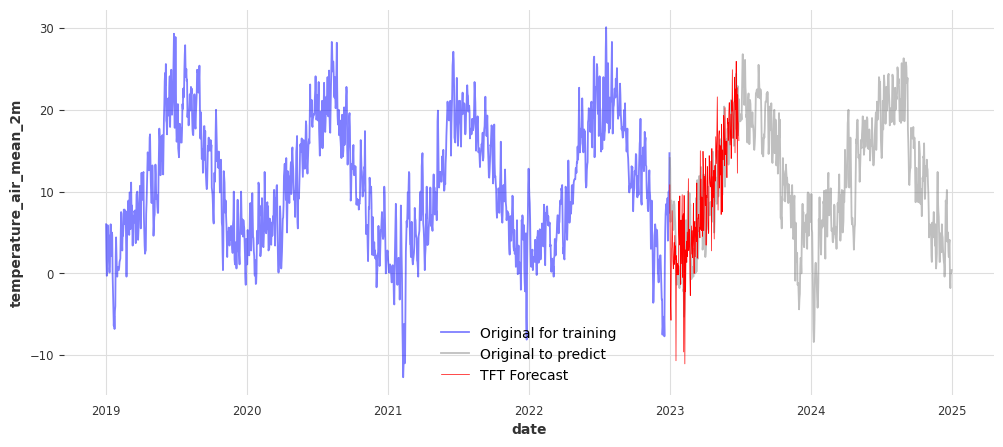

In [22]:
# Inverse transform the predictions back to original scale
pred_tft_series = transformer_target.inverse_transform(pred_tft).pd_series()

fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(x=df_temp_visu.loc[:"2022"].index, y=df_temp_visu.loc[:"2022"], alpha=0.5, color='blue', label='Original for training', ax=ax)
sns.lineplot(x=df_temp_visu.loc["2023":].index, y=df_temp_visu.loc["2023":], alpha=0.5, color='grey', label='Original to predict', ax=ax)
sns.lineplot(x=pred_tft_series.index, y=pred_tft_series, color='red', linewidth=0.5, label=f'TFT Forecast', ax=ax)
plt.show()

### Backtesting with Historical Forecasts

This step simulates how the model would have performed if it were making predictions in the past. Backtesting allows us to evaluate the model in a realistic, rolling forecast scenario unsing moving time windows, which is essential for deployment confidence.

In [23]:
# Run historical forecasts
historical_forecasts = pretrained_tft_model.historical_forecasts(
    series=train_transformed,
    past_covariates=past_covs_train_transformed,
    start=pd.Timestamp("2019"),
    forecast_horizon=1,
    stride=1,
    retrain=False,
    verbose=True
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/matthias/Documents/Miniconda/envs/tsa-transformer-env/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: PossibleUserWarning:

GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



Predicting: |          | 0/? [00:00<?, ?it/s]

In [24]:
# Align true values and forecast for scoring
intersect = train_transformed.slice_intersect(historical_forecasts)
rmse_val = rmse(intersect, historical_forecasts)
mape_val = mape(intersect, historical_forecasts)
print(rmse_val, mape_val)

0.07060553 9.440534


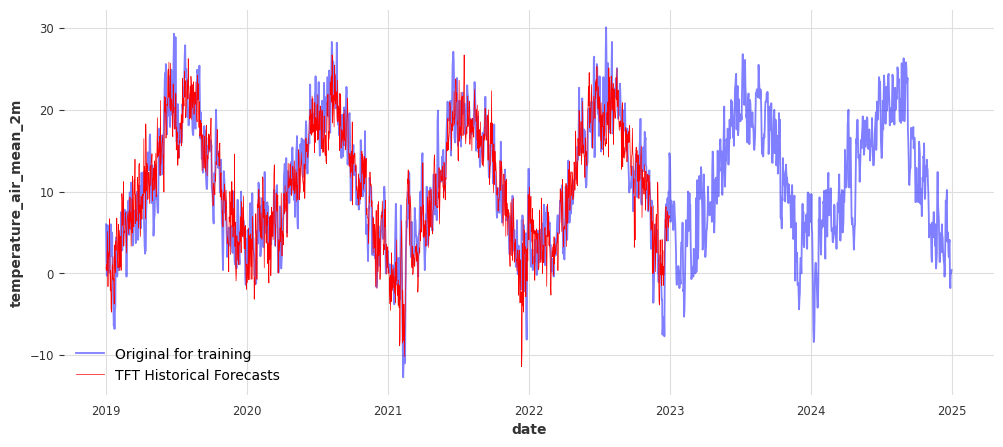

In [25]:

# Inverse transform the historical forecasts back to original scale
historical_forecasts_series = transformer_target.inverse_transform(historical_forecasts).pd_series()

fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(x=df_temp_visu.index, y=df_temp_visu, alpha=0.5, color='blue', label='Original for training', ax=ax)
sns.lineplot(x=historical_forecasts_series.index, y=historical_forecasts_series, color='red', linewidth=0.5, label=f'TFT Historical Forecasts', ax=ax)
plt.show()